In [1]:
import numpy as np
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

# We want our experiment to be reproducible
np.random.seed(42)
tf.set_random_seed(42)

# This setting allows Tensorflow to allocate GPU memory in runtime rather than at the session initialization.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'
validation_data_dir = 'data/validation'

img_height = 299
img_width = 299

# You may need to decrease batch size depending on your GPU capacity
batch_size = 16
epochs = 10

train_first_class = 2000
train_second_class = 2000

val_first_class = 1000
val_second_class = 1000

nb_train_samples = train_first_class + train_second_class
nb_validation_samples = val_first_class + val_second_class

In [3]:
from keras.layers import Input
from keras.applications import xception
from keras.preprocessing import image

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Found 4000 images belonging to 2 classes.
Prediction of the training set finished.
Found 2000 images belonging to 2 classes.
Prediction of the validation set finished.


In [4]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array(([0] * train_first_class) + ([1] * train_second_class))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array(
        [0] * (val_first_class) + [1] * (val_second_class))

In [14]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import Dropout, Dense

model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(lr=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 0s - loss: 0.4672 - acc: 0.8277 - val_loss: 0.2052 - val_acc: 0.9895
Epoch 2/10
4000/4000 [==============================] - 0s - loss: 0.1739 - acc: 0.9745 - val_loss: 0.0748 - val_acc: 0.9910
Epoch 3/10
4000/4000 [==============================] - 0s - loss: 0.1041 - acc: 0.9777 - val_loss: 0.0483 - val_acc: 0.9920
Epoch 4/10
4000/4000 [==============================] - 0s - loss: 0.0744 - acc: 0.9850 - val_loss: 0.0370 - val_acc: 0.9925
Epoch 5/10
4000/4000 [==============================] - 0s - loss: 0.0608 - acc: 0.9842 - val_loss: 0.0319 - val_acc: 0.9935
Epoch 6/10
4000/4000 [==============================] - 0s - loss: 0.0554 - acc: 0.9872 - val_loss: 0.0290 - val_acc: 0.9935
Epoch 7/10
4000/4000 [==============================] - 0s - loss: 0.0501 - acc: 0.9868 - val_loss: 0.0274 - val_acc: 0.9940
Epoch 8/10
4000/4000 [==============================] - 0s - loss: 0.0508 - a

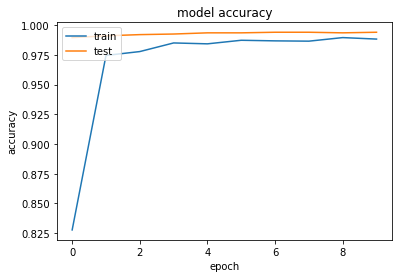

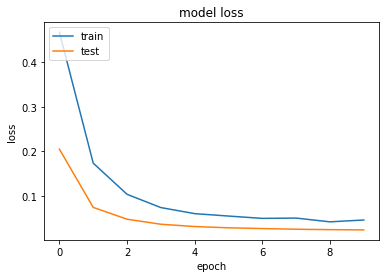

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
from keras.models import Model

batch_size = 8
epochs = 5

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_width, img_height, 3),
                                            pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(1, activation='sigmoid'))

top_model.load_weights('top-weights.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='binary_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/5
500/500 [==============================] - 251s - loss: 0.1218 - acc: 0.9577 - val_loss: 0.0271 - val_acc: 0.9935
Epoch 2/5
500/500 [==============================] - 248s - loss: 0.0703 - acc: 0.9798 - val_loss: 0.0208 - val_acc: 0.9945
Epoch 3/5
500/500 [==============================] - 248s - loss: 0.0659 - acc: 0.9798 - val_loss: 0.0205 - val_acc: 0.9945
Epoch 4/5
500/500 [==============================] - 251s - loss: 0.0566 - acc: 0.9825 - val_loss: 0.0216 - val_acc: 0.9925
Epoch 5/5
500/500 [==============================] - 251s - loss: 0.0364 - acc: 0.9898 - val_loss: 0.0186 - val_acc: 0.9955


In [26]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])

Found 10000 images belonging to 2 classes.
Loss:  0.0448743769939 Accuracy:  0.96875
